# HW10 CS395 apfriedr 4/24/2023

What are the challenges associated with outlier detection in data analysis, and how do different types of
outliers affect the process of identifying and managing outliers in a dataset? Provide technical reasoning
to support your answer

Outlier detection is the process of identifying data points that are very different from expectation. There are several problems typical to outlier analysis or anomaly detection. outliers can be global or contextual - dependent on other data they come with, or completely and obviously apart in their value. There can also be collective outliers, such as orders through a day that are delayed. This delay may or may not be caused by the same mechanism, despite us identifyinng this group using the same methodology. Outlier detection depends on the dsitribution or modeling of non-outliers. Therefore if this modeling is done poorly or is very noise, it can very difficult to tell what is and what isn't an outlier, or to be able to trust the results of detection. Choosing the similarity/distance measure to detect outliers is often also application dependent, meaning some amount of domain knowledge is likely required to detect outliers. Finally, we may be able to detect outliers but also want to know \textit{why} they are outliers, which may not always be possible. We can use statistical methods to judge the probability of two outliers in relationship to each other, which may gives us some notion of whether they were generated by the same mechanism. 

Supervised and unsupervised methods are both used to detect outliers. Supervised methods involve labeling and classifying whether data is likely to be part of the built model. Two challenges that can occur are data imbalance, and sometimes the recall is more important than the simple labelling. For unsupervised methods, clustering is often applied. This relies on an assumption that the data points are clustered inn some way to begin with. Data points not belonging to a cluster are marked as outliers. This can lead to fallacious results when using large datasets, unless small groups of indiidual points are identified as outlier clusters as well.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2
from numpy.linalg import inv
import seaborn as sns

In [2]:
np.random.seed(123)  # For reproducibility

# Generate synthetic multivariate dataset with outliers
n_samples = 1000  # Number of samples
n_features = 5  # Number of features
n_outliers = np.random.randint(100, 150)  # Number of outliers
mean = np.zeros(n_features)
cov = np.identity(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
outliers = np.random.uniform(low=-10, high=10, size=(n_outliers, n_features))
data = np.concatenate((data, outliers), axis=0)
data = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(n_features)])
data.to_csv('synthetic_dataset.csv', index=False)


In [3]:
# Load the synthetic dataset from the "synthetic_dataset.csv" file into a pandas DataFrame
df = pd.read_csv("synthetic_dataset.csv", header=0)

print(df.head(10))


   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0  -0.952097  -0.745441   1.738370   0.406454   0.322106
1  -0.051518  -0.204201   1.979348  -1.619300  -1.113964
2  -0.447441   1.668402  -0.143372  -0.619191  -0.769433
3   0.576746   0.126526  -1.301489   2.207427   0.522742
4   0.465645   0.724915   1.495827   0.746581  -1.100985
5  -1.410301  -0.747651  -0.984868  -0.748569   0.240367
6  -1.855637  -1.779455  -2.750224  -0.234158  -0.695981
7  -1.774134   2.361601   0.034993  -0.344642  -0.725032
8   1.039606  -0.241728  -0.112905  -1.660696   0.013539
9   0.337374  -0.926623   0.275747   0.370852   1.174307


In [4]:
def grubbs_test(df, alpha):
    # Calculate the mean and standard deviation for each column of the DataFrame
    mean = df.mean()
    std_dev = df.std()
    
    # Calculate the test statistic for each column of the DataFrame
    G = abs(df - mean) / std_dev
    max_G = G.max(axis=1)
    
    # Calculate the critical value from the t-distribution
    n = df.shape[0]
    t = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    critical_value = (n - 1) / np.sqrt(n) * np.sqrt(np.square(t) / (n - 2 + np.square(t)))
    
    # Return a Boolean mask indicating which rows are identified as outliers
    return max_G > critical_value


In [5]:
# Mahalanobis distance
def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

def find_outliers_mahalanobis(df, mahal_dist_col, alpha=0.05):
    """
    Find outliers using Mahalanobis distance and a given significance level (alpha).
    
    Parameters:
    df (pandas.DataFrame): DataFrame with the Mahalanobis distances calculated in a column.
    mahal_dist_col (str): The name of the column containing Mahalanobis distances.
    alpha (float): Significance level to determine outliers (default is 0.05).
    
    Returns:
    pandas.Series: A boolean mask indicating whether each row is an outlier (True) or not (False).
    """
    
    # Calculate degrees of freedom (number of variables/features)
    df_features = df.drop(columns=[mahal_dist_col])
    num_features = df_features.shape[1]

    # Calculate Chi-squared critical value for the given alpha
    chi2_critical_value = stats.chi2.ppf(1 - alpha, num_features)

    # Create a boolean mask for outliers
    outliers_mask = df[mahal_dist_col] > chi2_critical_value
    
    return outliers_mask

In [6]:
# Chi-square statistical approach.


In [7]:
def plot_outliers_boxplot(df, outliers, test_name):
    # Print the indices of the rows identified as outliers
    print(df[outliers].index)

    # Create a box plot of the non-outlier data
    non_outliers = df[~outliers]
    non_outliers.plot(kind='box')

    # Plot the outliers as separate points
    outlier_rows = df[outliers]
    plt.plot(range(1, df.shape[1] + 1), outlier_rows.values.T, 'ro')

    # Set the title and labels for the plot
    plt.title('Box plot of data with outliers detected by {test_name} test'.format(test_name=test_name))
    plt.xlabel('Features')
    plt.ylabel('Values')

    # Show the plot
    plt.show()

In [8]:
def plot_outliers_scatterplot(df, outliers, test_name):
    # Create a scatter plot of the data, coloring the outliers differently
    sns.scatterplot(data=df, x='Feature_1', y='Feature_2', hue=outliers, palette=['blue', 'red'])

    # Set the title and labels for the plot
    plt.title('Scatter plot of data with outliers detected by {test_name} test'.format(test_name = test_name))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Show the plot
    plt.show()

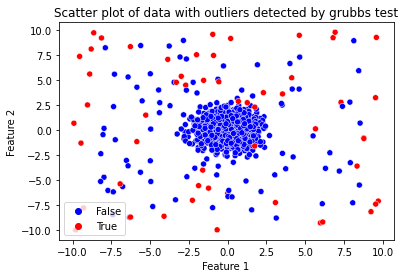

Int64Index([1000, 1002, 1009, 1012, 1019, 1020, 1023, 1026, 1028, 1032, 1034,
            1035, 1036, 1037, 1040, 1041, 1044, 1045, 1051, 1055, 1057, 1059,
            1060, 1068, 1069, 1070, 1071, 1073, 1074, 1075, 1076, 1078, 1081,
            1084, 1085, 1087, 1099, 1102, 1110, 1111, 1112, 1114, 1115, 1117,
            1120, 1124, 1125, 1127, 1128, 1129, 1131, 1133, 1134, 1135, 1140],
           dtype='int64')


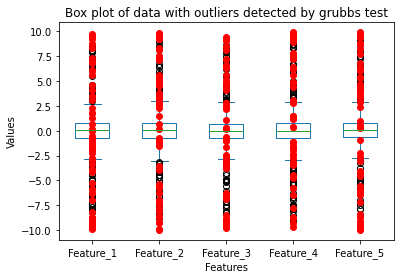

In [9]:
# Apply the Grubbs' test with a significance level of 0.05
grubbs_outliers = grubbs_test(df, 0.05)
plot_outliers_scatterplot(df, grubbs_outliers, "grubbs")
plot_outliers_boxplot(df, grubbs_outliers, "grubbs")

In [10]:
# Apply the Mahalanobis outlier detection with a significance level of 0.05
df_mahal = df.copy()
df_mahal['calculateMahalanobis'] = calculateMahalanobis(y=df, data=df[['Feature_1',  'Feature_2',  'Feature_3',  'Feature_4' ,'Feature_5']])
# df['p'] = 1 - chi2.cdf(df['Mahalanobis'], 4)




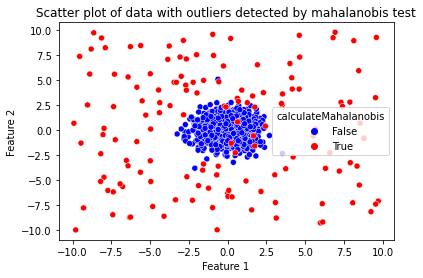

Int64Index([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
            ...
            1134, 1135, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144],
           dtype='int64', length=141)


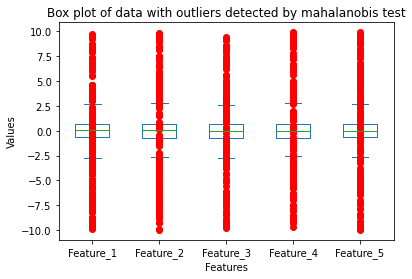

In [11]:
mahal_outliers = find_outliers_mahalanobis(df_mahal, "calculateMahalanobis")
plot_outliers_scatterplot(df, mahal_outliers, "mahalanobis")
plot_outliers_boxplot(df, mahal_outliers, "mahalanobis")

In [12]:
def find_outliers_chi_squared(df, alpha=0.05):
    """
    Find outliers using Chi-squared statistic approach on a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing numeric data.
    alpha (float): Significance level to determine outliers (default is 0.05).
    
    Returns:
    pandas.Series: A boolean mask indicating whether each row is an outlier (True) or not (False).
    """
    # Calculate z-scores for each value in the DataFrame
    z_scores = np.abs(stats.zscore(df))

    # Calculate the Chi-squared statistic for each row (sum of squares of z-scores)
    chi2_stat = np.sum(z_scores**2, axis=1)

    # Calculate degrees of freedom (number of variables/features)
    num_features = df.shape[1]

    # Calculate Chi-squared critical value for the given alpha
    chi2_critical_value = stats.chi2.ppf(1 - alpha, num_features)

    # Create a boolean mask for outliers
    outliers_mask = chi2_stat > chi2_critical_value

    return pd.Series(outliers_mask, index=df.index)



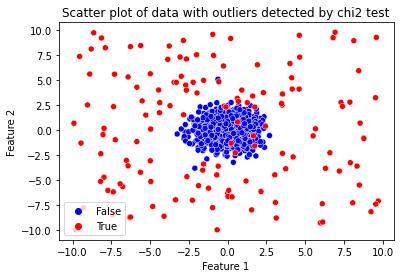

Int64Index([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
            ...
            1134, 1135, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144],
           dtype='int64', length=142)


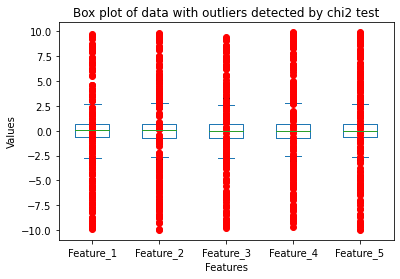

In [15]:
chi2_outliers = find_outliers_chi_squared(df)
plot_outliers_scatterplot(df, chi2_outliers, "chi2")
plot_outliers_boxplot(df, chi2_outliers, "chi2")


# Analysis of outlier detection methods

I plotted scatterplots of feature one vs feature 2 for each test detection method. It would be possible to plot the cartesian product of the features, but that amount of output seemed excessive -
particularly given that visually, the detected outliers are mainly dependent on these first 2 features. The detection methods worked well, finding points mostly outside of the main feature 1 and 2 cluster.
In the box plots, it can be seen that Grubbs' test did a better job of findinng outliers, particularly for features 3 and 5. If one wanted to go more in depth on this analysis, I would suggest to do a principal 
components analysis to aid in the visualization of clusters and outliers to those clusters. This would likely mitigate the problem of having many features, by reducing the dimensions of the data. Finally, comparing the actual outliers detected, it seems that all 3 methods detected many of the same outliers, while Grubbs' test only detected around 1/3 as many. We expect 100-150 outliers given our sythetic data, and both chi2 and Mahalanobis detected 142 and 141 respectively, while Grubbs' was about 55. This suggests that Grubbs' test was less reliable than either of the other 2 tests, or at least more stringent in what it consdered an outlier. 